In [1]:
import pandas as pd

from src.utils.train_utils import *
from src.utils.test_utils import *
from src.utils.feature_analyzer import *
from src.utils.plot_utils import *

### Import the data

In [2]:
train_df_path = '../../data/synth_data_train_labeled.csv'
test_df_path = '../../data/synth_data_test_labeled.csv'
supp_df_path = '../../data/synth_data_train_supplement.csv'
fi_dir = 'feature_importance'
target_model_dir = "../../model"

In [3]:
cols_to_drop = ['checked', 'Ja', 'Nee']
train_df = add_checked(pd.read_csv(train_df_path))
X_train = train_df.astype(np.float32)
y_train = train_df['checked']

In [4]:
test_df = add_checked(pd.read_csv(test_df_path))
X_test = test_df.drop(cols_to_drop, axis=1)
X_test = X_test.astype(np.float32)
y_test = test_df['checked']

### Manipulate the data

In [5]:
# Manipulate the data to reduce/increase bias
def data_manipulator(X, y, supp_path=None, remove_features=1, add_supp=0, overwrite=0, verbose=0):
    ########INSERT DATA MANIPULATION CODE HERE##########
    
    if add_supp:
        supp_df = add_checked(pd.read_csv(supp_path)).astype(np.float32)
        # Append the rows of df2 to df1
        augmented_X_df = pd.concat([X, supp_df], ignore_index=True)
        X = augmented_X_df
        supp_y = supp_df['checked']
        augmented_y_df = pd.concat([y, supp_y], ignore_index=True)
        y = augmented_y_df
    
        if overwrite:
            # Save the combined DataFrame to a new CSV file
            augmented_X_df.to_csv(train_df_path, index=False)
            print(f'Wrote to file {train_df_path}')

        print("Data augmentation complete.")
        print(augmented_X_df.shape)
    
    if remove_features:
        problem_features = filter_features(X.columns)
    
        for feature in problem_features:
            X[feature] = X[feature].mean() # Average values of problematic features to effectively 'remove' them from the model
            if verbose:
                print(f'Feature {feature} has been processed.')
        print("Feature processing complete.")
    return X, y
    ####################################################

X_prime, y_prime = data_manipulator(X_train, y_train, supp_path=supp_df_path, remove_features=1, add_supp=1, overwrite=0, verbose=0) # only set overwrite to 1 if you want to add supplementary data to csv and set back to 0 afterwards. Do not run twice!

Data augmentation complete.
(112300, 318)
Feature processing complete.


### Evaluate feature importances

In [6]:
latest_ver_name = get_versioned_name(fi_dir, 'fi_v', '.pkl', create_new=False) # set to true to create new version
latest_ver_path = fi_dir + '/' + latest_ver_name

## uncomment if you need to re-evaluate
# fa1 = FeatureAnalyzer()
# fa1.evaluate_importance(dataframe=X_prime, target='checked', add_drop=['Ja', 'Nee'], filepath=latest_ver_path) # Uncomment this line if you don't have the feature_importance.pkl file

In [7]:
if all(col in X_prime.columns for col in cols_to_drop):
    X_prime = X_prime.drop(['checked', 'Ja', 'Nee'], axis=1)
    
print(f'Loading feature importance data from {latest_ver_name}')

print(latest_ver_path)

Loading feature importance data from fi_v3.pkl
feature_importance/fi_v3.pkl


In [8]:
fa2 = FeatureAnalyzer()
fa2.load_importance(filepath=latest_ver_path)

In [9]:
fad = fa2.feature_importance_as_dict(column_names=X_prime.columns, normalize=True)

sorted_fi = dict(sorted(fad.items(), key=lambda item: item[1], reverse=True)[:10])

print("Top 10 most important features according to permutation importance:")
for rank, feature in enumerate(sorted_fi):
    print(f'{rank+1}: {feature} - {sorted_fi[feature]:.4f}')

Top 10 most important features according to permutation importance:
1: persoon_leeftijd_bij_onderzoek - 1.0000
2: pla_historie_ontwikkeling - 0.5988
3: ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden - 0.4292
4: instrument_ladder_huidig_activering - 0.2755
5: relatie_overig_actueel_vorm__kostendeler - 0.2754
6: contacten_onderwerp_no_show - 0.2267
7: pla_hist_pla_categorie_doelstelling_16 - 0.1951
8: ontheffing_reden_hist_tijdelijke_ontheffing_arbeidsverpl__en_tegenprestatie - 0.1862
9: instrument_reden_beeindiging_historie_succesvol - 0.1796
10: contacten_soort_afgelopenjaar_document__uitgaand_ - 0.1554


In [10]:
X_en, top_features_en = translate_cols(X_prime, sorted_fi)

print("Top 10 most important features according to permutation importance (normalized):")
for rank, feature in enumerate(top_features_en):
    print(f'{rank+1}: {feature} - {top_features_en[feature]:.4f}')

Top 10 most important features according to permutation importance (normalized):
1: person_age_at_investigation - 0.2839
2: pla_history_development - 0.1700
3: exemption_days_hist_due to_your_medical_conditions - 0.1219
4: instrument_ladder_current_activation - 0.0782
5: relationship_other_current_form_cost_sharer - 0.0782
6: contacts_subject_no_show - 0.0644
7: pla_hist_pla_category_objective_16 - 0.0554
8: exemption_reason_hist_temporary_dispensation_work_shift_and_compensation - 0.0529
9: instrument_reason_termination_history_successful - 0.0510
10: contacts_type_last_year_document_outgoing - 0.0441


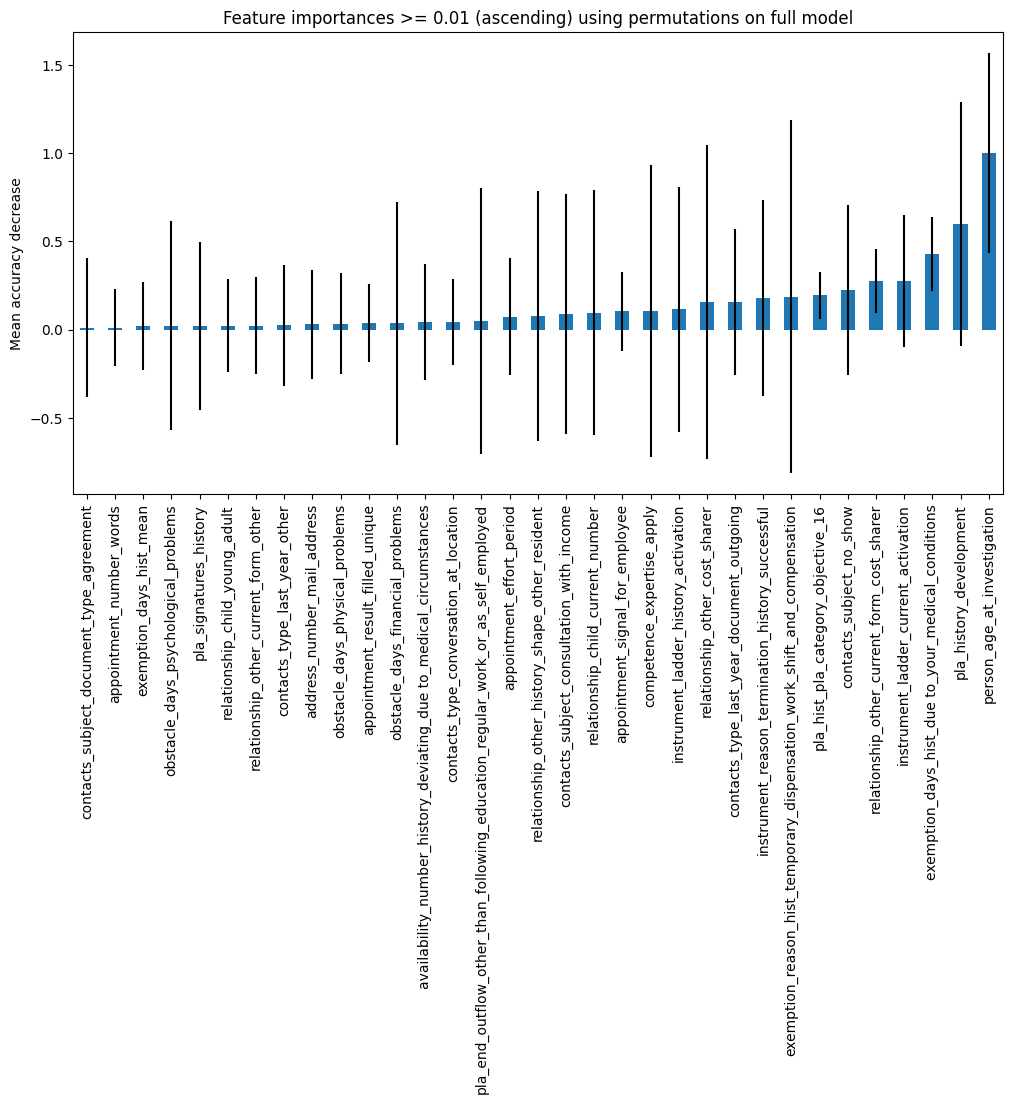

In [11]:
fa2.plot_importance(column_names=X_en.columns, min_val=0.01)

### Visualize modified data distributions (Top 3)

Mean:11222.6
{'18-23': 10200, '23-28': 8600, '28-33': 5900, '33-38': 1600, '62-67': 1800}


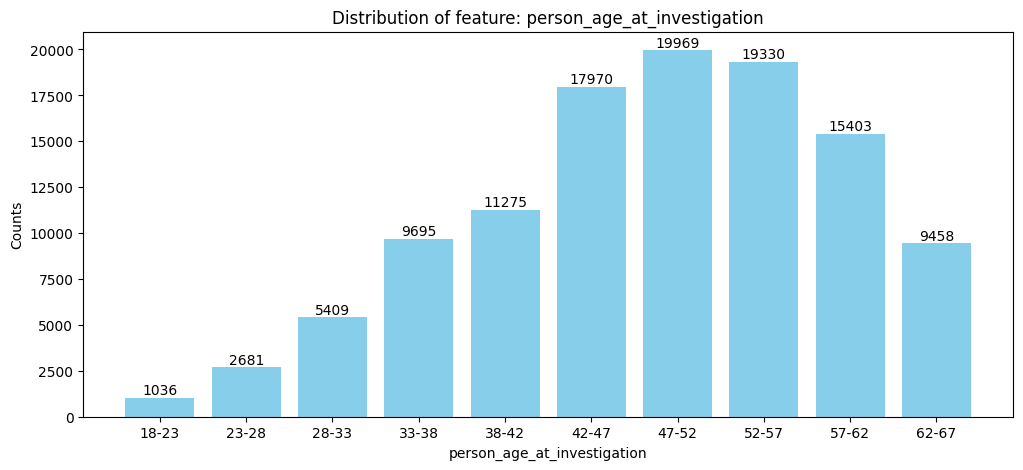

Mean:56150.0
Differences with mean: {0.0: 5800}


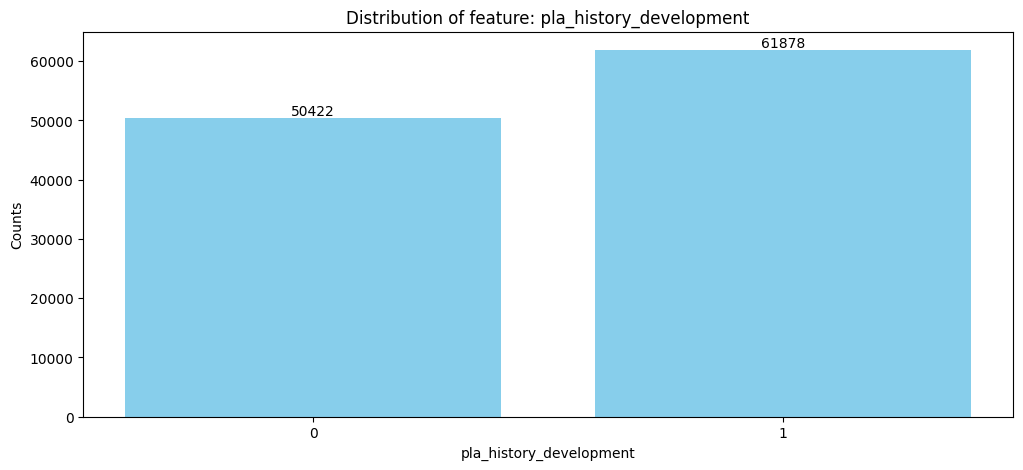

Mean:11229.9
{'3470-4338': 3400, '4338-5206': 8300, '5206-6073': 10400, '6073-6941': 11000, '6941-7808': 11200, '7808-8676': 11300}


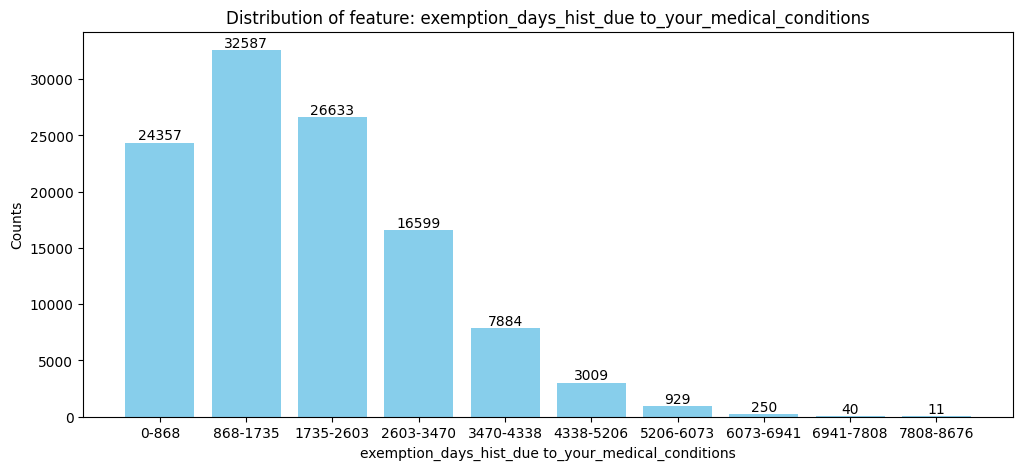

In [12]:
for feature in list(top_features_en.keys())[:3]:
    plot_distribution(X_en[feature], feature)

### Train model on modified data

In [13]:
# uncomment to train new model
model_path = target_model_dir + '/' + get_versioned_name(target_model_dir, 'gboost1_v', '.onnx', create_new=True) # set to true to create new version
run(X_prime, y_prime, model_path)

# model_path = target_model_dir + '/' + get_versioned_name(target_model_dir, 'gboost1_v', '.onnx', create_new=False) # set to true to create new version

Training model.....
Fitting 2 folds for each of 9 candidates, totalling 18 fits
      Iter       Train Loss   Remaining Time 
         1           0.7951            8.41m
         2           0.7410            8.26m
         3           0.6968            8.30m
         4           0.6628            8.30m
         5           0.6403            8.23m
         6           0.6173            8.20m
         7           0.5974            8.18m
         8           0.5798            8.16m
         9           0.5629            8.16m
        10           0.5501            8.15m
        20           0.4547            7.97m
        30           0.4033            7.81m
        40           0.3694            7.65m
        50           0.3455            7.47m
        60           0.3267            7.31m
        70           0.3122            7.13m
        80           0.2999            6.97m
        90           0.2903            6.80m
       100           0.2817            6.64m
       200         

In [14]:
# Let's load the model
new_session = rt.InferenceSession(model_path)

# Let's predict the target
y_pred_onnx =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.9512
